# Guide
## Data
[[Google Drive] /Data/Final/Step2-2.zip](https://drive.google.com/file/d/19ARNrbgWSn-Wi5k7uXKehJnzmvbIRThv/view?usp=sharing)
## Code
In [3] `base_dir` : 실제 데이터 경로로 변경 필요

---

# Purpose
- 모델 성능 향상  
- validation 그래프 진동 폭 감소  

## Alternation
(compared to `3. ReduceLROnPlateau`)   
`Dropout(0.3)` → `Dropout(0.4)`

In [1]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import os

2024-11-23 18:41:32.315734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = (400, 400)
batch_size = 32

In [3]:
# 데이터셋 로드
from tensorflow.keras.utils import image_dataset_from_directory

# 실제 데이터의 경로로 변경 필요
base_dir = "/tf/Fixed_Data/Data_Final/Step2-2"

train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size)

Found 11340 files belonging to 18 classes.
Found 3240 files belonging to 18 classes.


2024-11-23 18:41:34.004606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-23 18:41:34.007967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-23 18:41:34.008060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 1620 files belonging to 18 classes.


### Dropout Ratio 증가

In [4]:
# 모델 레이어 구성
inputs = keras.Input(shape=(400, 400, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3)(x)
x = layers.Conv2D(filters=256, kernel_size=3)(x)   
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=512, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.4)(x)   # Dropout(0.3)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.4)(x)   # Dropout(0.3)
x = layers.Dense(256, activation = "relu")(x)   

outputs = layers.Dense(18, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 398, 398, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 398, 398, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496 

In [6]:
# 학습률 및 옵티마이저 설정
optimizer = optimizers.RMSprop(learning_rate=1e-4)

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # 검증 손실을 기준으로 학습 중단
    patience=5,               # 성능이 개선되지 않는 에포크 수 (5회 연속 개선 없을 시 중단)
    restore_best_weights=True # 최적의 가중치 복원
)

In [8]:
callbacks = [keras.callbacks.ReduceLROnPlateau(
                                monitor='val_loss',   # 검증 손실 기준
                                factor=0.5,           # 학습률 절반으로 감소
                                patience=3),          # 3회 연속 개선 없을 경우
            early_stopping]

In [9]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=callbacks,   # EarlyStopping, ReduceLROnPlateau 설정
    batch_size=batch_size)

Epoch 1/100


2024-11-23 18:41:35.475122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-23 18:41:36.108130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-23 18:41:36.606427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-23 18:41:36.624615: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x82691c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-23 18:41:36.624635: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-23 18:41:36.627836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] 

355/355 [==============================] - 42s 106ms/step - loss: 2.1065 - accuracy: 0.4299 - val_loss: 1.3715 - val_accuracy: 0.5645 - lr: 1.0000e-04
Epoch 2/100
355/355 [==============================] - 37s 102ms/step - loss: 1.3586 - accuracy: 0.5766 - val_loss: 1.0882 - val_accuracy: 0.6537 - lr: 1.0000e-04
Epoch 3/100
355/355 [==============================] - 37s 102ms/step - loss: 1.1408 - accuracy: 0.6436 - val_loss: 0.8900 - val_accuracy: 0.7306 - lr: 1.0000e-04
Epoch 4/100
355/355 [==============================] - 37s 102ms/step - loss: 1.0062 - accuracy: 0.6859 - val_loss: 0.7880 - val_accuracy: 0.7546 - lr: 1.0000e-04
Epoch 5/100
355/355 [==============================] - 37s 102ms/step - loss: 0.9387 - accuracy: 0.7091 - val_loss: 0.7508 - val_accuracy: 0.7546 - lr: 1.0000e-04
Epoch 6/100
355/355 [==============================] - 37s 102ms/step - loss: 0.8581 - accuracy: 0.7341 - val_loss: 1.0564 - val_accuracy: 0.6673 - lr: 1.0000e-04
Epoch 7/100
355/355 [=============

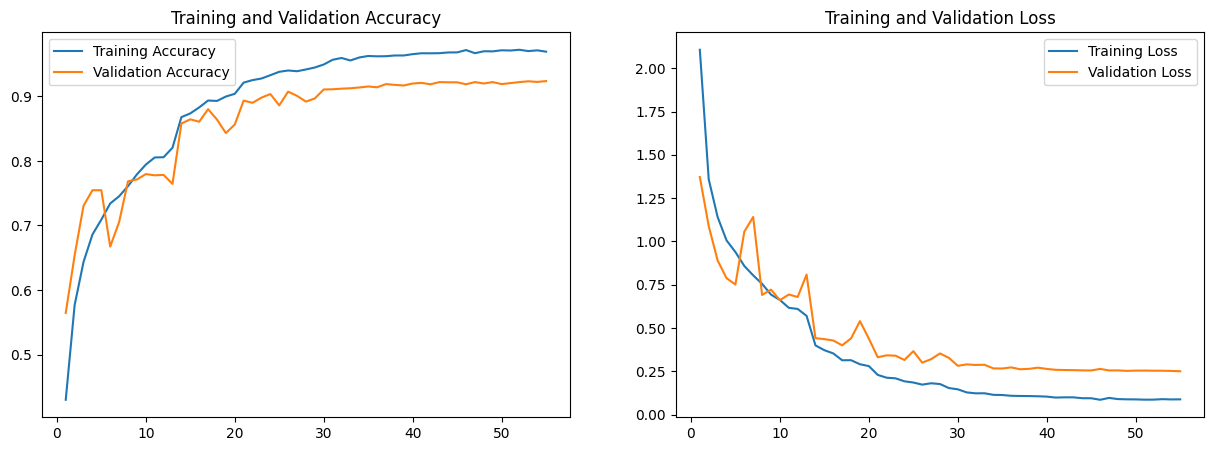

In [10]:
# 훈련 정확도와 손실 그래프 생성
import matplotlib.pyplot as plt 

acc = history.history['accuracy'][:-5]           
val_acc = history.history['val_accuracy'][:-5]   
loss = history.history['loss'][:-5]              
val_loss = history.history['val_loss'][:-5]      
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Analysis - Training & Validation
## 불안정
(compared to `3.ReduceLROnPlateau`)  
약 25 Epoch 이후부터 안정적인 형태의 그래프

---

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"test accuracy: {test_acc}")
print(f"test loss: {test_loss}")

51/51 [==============================] - 3s 47ms/step - loss: 0.2751 - accuracy: 0.9074
test accuracy: 0.9074074029922485
test loss: 0.275071918964386


# Analysis - Test
(compared to `3.ReduceLROnPlateau`)  
Accuracy : 89.4% → 90.7%  
Loss : 0.3665 → 0.2751  
성능 소폭 향상